In [1]:
import cv2
import time
import math
import numpy as np
import os    
from scipy.fftpack import fft, fftfreq, fftshift,ifft,fft2,ifft2,ifftn,ifftshift
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
# from libsmop import *
%matplotlib inline

**POINT SOURCE**

In [3]:

def point_src(M,z,x0,y0,lamda,dx):
  N = M
  
  dy=dx
  m,n=np.meshgrid(np.linspace(1-M/2,M/2,M),np.linspace(1-N/2,N/2,N))
  k=2*np.pi/lamda
  r=np.sqrt(z**2+(m*dx-x0)**2+(n*dy-y0)**2)
  P=np.exp(1j*k*r)/r
  return P
# p=point_src(3,1.228e-3,0,0,532e-9,6.86e-3)
# print(p)

**HoloInterpF**

In [4]:
def holo_interpF(Min,lambda_,z,deltax):


    #Neccesary parameters
    row,__=Min.shape
    
    #Coordinates transformation required
    Xc,Yr=np.meshgrid(np.linspace(0,row,row),np.linspace(0,row,row))
    X=np.dot(deltax,(Xc - row / 2)) / (np.dot(lambda_,z))
    Y=np.dot(deltax,(Yr - row / 2)) / (np.dot(lambda_,z))
    Xp=np.dot(np.dot(lambda_,X),z) / np.sqrt(1 - np.dot((lambda_ ** 2),(X ** 2 + Y ** 2)))
    Yp=np.dot(np.dot(lambda_,Y),z) / np.sqrt(1 - np.dot((lambda_ ** 2),(X ** 2 + Y ** 2)))
    
    #Length of the coordinates matrix in pixels
    limit=np.ceil(np.max(np.max(Xp / deltax)))
    
    #Displace the origin of coordinates
    Xp=Xp - np.min(np.min(Xp))
    Yp=Yp - np.min(np.min(Yp))
    #Coordinates in pixel units
    Xp_p=(Xp) / deltax 
    Yp_p=(Yp) / deltax 
    
    #Positions to asign the displacement values
    iXp=(np.floor(Xp_p)).astype('int64')
    iYp=(np.floor(Yp_p)).astype('int64')
    
    #Calculate the weights for the neares
    x1frac=(iXp + 1.0) - Xp_p    
    x2frac=1.0 - x1frac    
    y1frac=(iYp + 1.0) - Yp_p
    y2frac=1.0 - y1frac
    x1y1=(np.multiply(x1frac,y1frac))  
    x1y2=(np.multiply(x1frac,y2frac)) 
    x2y1=(np.multiply(x2frac,y1frac))
    x2y2=(np.multiply(x2frac,y2frac))
    
    #Pre-allocate the interpolated hologram
    
    Mout=np.zeros((int(np.dot(2,limit)),int(np.dot(2,limit))),dtype=complex)
    
    #Interpolation process
    for it in np.arange(0,row-1):
        
        for jt in np.arange(0,row-1):          
            
            Mout[iYp[it,jt],iXp[it,jt]]=Mout[iYp[it,jt],iXp[it,jt]] + x1y1[it,jt]*Min[it,jt]    
            Mout[iYp[it,jt],iXp[it,jt] + 1]=Mout[iYp[it,jt],iXp[it,jt] + 1] + x2y1[it,jt]*Min[it,jt]
            Mout[iYp[it,jt] + 1,iXp[it,jt]]=Mout[iYp[it,jt] + 1,iXp[it,jt]] + x1y2[it,jt]*Min[it,jt]
            Mout[iYp[it,jt] + 1,iXp[it,jt] + 1]=Mout[iYp[it,jt] + 1,iXp[it,jt] + 1] + x2y2[it,jt]*Min[it,jt]
    
    #Crop to the size of the camera    
    Mout=Mout[int((np.dot(2,limit) - row) / 2):int(((np.dot(2,limit) + row) / 2)),int((np.dot(2,limit) - row) / 2):int(((np.dot(2,limit) + row) / 2))]
    return Mout

**COSINE FILTER**

In [5]:

def filtcosenoF(par,fi): 
    #Coordenadas
    Xfc,Yfc=np.meshgrid(np.linspace(- fi / 2,fi / 2,fi),np.linspace(fi / 2,- fi / 2,fi))
    # Normalizar cooredenadas en intervalo (-pi, pi) y crear filtros en
    # dirección horizontal y vertical
    FC1=np.cos(np.dot(np.dot(Xfc,(np.pi / par)),(1 / np.max(np.max(Xfc))))) ** 2
    FC2=np.cos(np.dot(np.dot(Yfc,(np.pi / par)),(1 / np.max(np.max(Yfc))))) ** 2
    #Intersectar ambas direcciones
    FC=np.multiply(np.multiply(np.multiply((FC1 > 0),(FC1)),(FC2 > 0)),(FC2))
    #Re-escalar de 0 a 1
    FC=FC / np.max(np.max(FC))
    # print(FC)
    
    return FC
# FC=filtcosenoF(100,5)

**PREPAIR HOLOGRAM**

In [6]:
# % USER FUNCTION TO PREPARE THE HOLOGRAM USING NEAREST NEIGHBOOR INTERPOLATION
def prepairholoF(CH_m,xop,yop,Xp,Yp):

    size=np.shape(CH_m)
    row = size[0]
    #New coordinates measured in units of the -2*xop/(row) pixel size
    Xcoord = (Xp - xop)/(-2*xop/(row))
    Ycoord = (Yp - yop)/(-2*xop/(row))
    #Find lowest integer
    iXcoord= (np.floor(Xcoord)).astype('int')
    iYcoord= (np.floor(Ycoord)).astype('int')
    #Assure there isn't null pixel positions

    iXcoord[iXcoord == 0 ]=1
    iYcoord[iYcoord == 0 ]=1
    # Calculate the fractioning for interpolation
    x1frac=(iXcoord + 1.0) - Xcoord    
    x2frac=1.0 - x1frac   
    y1frac=(iYcoord + 1.0) - Ycoord
    y2frac=1.0 - y1frac
    x1y1=np.multiply(x1frac,y1frac)    
    x1y2=np.multiply(x1frac,y2frac)
    x2y1=np.multiply(x2frac,y1frac)
    x2y2=np.multiply(x2frac,y2frac)
    
    #Pre-allocate the prepared hologram
    CHp_m=np.zeros((row,row),dtype = complex)
    #Prepare hologram (preparation1 - every pixel remapping)
    for it in range(row-1):
        for jt in range(row-1):
            CHp_m[iYcoord[it,jt]-1,iXcoord[it,jt]-1]= CHp_m[iYcoord[it,jt]-1,iXcoord[it,jt]-1] + (x1y1[it,jt])*CH_m[it,jt]
            CHp_m[iYcoord[it,jt]-1,iXcoord[it,jt]]= CHp_m[iYcoord[it,jt]-1,iXcoord[it,jt]] + (x2y1[it,jt])*CH_m[it,jt]
            CHp_m[iYcoord[it,jt],iXcoord[it,jt]-1]= CHp_m[iYcoord[it,jt],iXcoord[it,jt]-1] + (x1y2[it,jt])*CH_m[it,jt]
            CHp_m[iYcoord[it,jt],iXcoord[it,jt]]= CHp_m[iYcoord[it,jt],iXcoord[it,jt]] + (x2y2[it,jt])*CH_m[it,jt]   
    return CHp_m 

**BLUESTEIN**

In [7]:
def bluestein3(field,z,lamda,dx_in,dx_out):
    
    M,N=field.shape
    m,n=np.meshgrid(np.linspace(1-M/2,M/2,M),np.linspace(1-N/2,N/2,N))

    padx=int(M/2)
    pady=int(N/2)    
    
    dX=dx_out/np.sqrt(1-(dx_out/z)**2*(m**2+n**2))
    dY=dx_out/np.sqrt(1-(dx_out/z)**2*(m**2+n**2))
    
    
    k=2*np.pi/lamda
    R=np.sqrt(z**2 + (m * dX)**2 + (n * dY)**2)
        
    out_phase=1/(1j*lamda*R)*np.exp(1j*k*R)*np.exp(-1j*0.5*k/R*((dx_in*dX*m**2)+(dx_in*dY*n**2)))
        
    f1=field*np.exp(1j*0.5*k/R*((dx_in*(dx_in-dX)*m**2)+(dx_in*(dx_in-dY)*n**2)))
    f2=np.exp(1j*0.5*k/R*((dx_in*dX*m**2)+(dx_in*dY*n**2)))
    
    f1=np.pad(f1, ((padx, padx), (pady, pady)), 'constant',constant_values=0)
    f2=np.pad(f2, ((padx, padx), (pady, pady)), 'constant',constant_values=0)
    
    F1=np.fft.fft2(f1)
    F2=np.fft.fft2(f2)
    
    out=np.fft.fftshift(np.fft.ifft2(F1*F2))
    out=out[padx:padx+M,pady:pady+N]
    out=out_phase*out
    return out

# b=bluestein3(p,1.228e-3,532e-9,6.86e-3,6.86e-3)
# print(b)

**KREUZER**

In [8]:

def kreuzer3F(CH_m,z,L,lambda_,deltax,deltaX,FC,str):
    #Square pixels:
    deltaY=deltaX
    #Matrix size
    size=np.shape(CH_m)
    row = size[0]
    #Parameters
    k=(2*np.pi )/ lambda_
    W= deltax*row
    #Matriz coordinates
    X,Y=np.meshgrid(np.arange(0,row),np.arange(0,row))
    #Hologram origin coordinates
    xo=- W / 2
    yo=- W / 2
    #Prepared Hologram, coordinates origin
    xop=xo*L / math.sqrt(L ** 2 + xo ** 2)
    yop=yo*L / math.sqrt(L ** 2 + yo ** 2)
    #Pixel size for the prepared hologram
    deltaxp=xop / (- row / 2)
    deltayp=deltaxp
    #Coordinates origin for the reconstruction plane
    Yo=np.dot(- deltaX,(row)) / 2
    Xo=np.dot(- deltaX,(row)) / 2
    Xp=np.dot(np.dot((deltax),(X - row / 2)),L) / np.sqrt(L ** 2 + np.dot((deltax ** 2),(X - row / 2) ** 2) + np.dot((deltax ** 2),(Y - row / 2) ** 2))
    Yp=np.dot(np.dot((deltax),(Y - row / 2)),L) / np.sqrt(L ** 2 + np.dot((deltax ** 2),(X - row / 2) ** 2) + np.dot((deltax ** 2),(Y - row / 2) ** 2))
    #Search for prepared hologram if needed
    current_folder = os.getcwd()    
    file= os.path.join(current_folder, str)
    #Preparation of the hologram when neccesary    
    if os.path.exists(file) == False:
        CHp_m=prepairholoF(CH_m,xop,yop,Xp,Yp)    
#    if exist(file,'file') == 0:
#        #Prepare holo
    # CHp_m=prepairholoF(CH_m,xop,yop,Xp,Yp)
## kreuzer3F.m:48
#        #    save(str,'CHp_m');
#    else:
#        #load .mat file with the saved prepared hologram
#        load(str)
    
    #Multiply prepared hologram with propagation phase    
    Rp=np.sqrt((L ** 2) - (np.dot(deltaxp,X) + xop) ** 2 - (np.dot(deltayp,Y) + yop) ** 2)
    r=np.sqrt(np.dot((deltaX ** 2),((X - row / 2) ** 2 + (Y - row / 2) ** 2)) + (z) ** 2)
    CHp_m= CHp_m*((L/Rp)**4)*np.exp(-0.5*1j*k*(r**2 - 2*z*L)*Rp/(L**2))
    ##.*exp(-(3/48)*1i*k*((L^2)./Rp).*((r.^2 - 2*z*L).*(Rp./(L^2)).^2).^3)...
    ##.*exp((15/384)*1i*k*((L^2)./Rp).*((r.^2 - 2*z*L).*(Rp./(L^2)).^2).^4);
    
    #Padding constant value
    pad=int(row / 2)
    #Padding on the cosine rowlter
    FC=np.pad(FC,(pad,pad), 'constant',constant_values=0)
    #Convolution operation
#First transform
    T1=np.multiply(CHp_m,np.exp(np.dot((np.dot(1j,k) / (np.dot(2,L))),(np.dot(np.dot(np.dot(2,Xo),X),deltaxp) + np.dot(np.dot(np.dot(2,Yo),Y),deltayp) + np.dot(np.dot((X) ** 2,deltaxp),deltaX) + np.dot(np.dot((Y) ** 2,deltayp),deltaY)))))
    T1=np.pad(T1,(pad,pad), 'constant',constant_values=0)
    T1=fftshift(fft2(fftshift(np.multiply(T1,FC))))
    #Second transform
    T2=np.exp(np.dot(np.dot(- 1j,(k / (np.dot(2,L)))),(np.dot(np.dot((X - row / 2) ** 2,deltaxp),deltaX) + np.dot(np.dot((Y - row / 2) ** 2,deltayp),deltaY))))
    T2=np.pad(T2,(pad,pad), 'constant',constant_values=0)
    T2=fftshift(fft2(fftshift(np.multiply(T2,FC))))
    #Third transform
    K=ifftshift(ifftn(ifftshift(np.multiply(T2,T1))))
    K=K[pad+1:pad+row,pad+1:pad+row]
    # K = K(pad+1:pad+row,pad+1:pad+row);#
    #Multiply by aditional terms after the propagation
# K = K.*deltaxp.*deltayp.*(exp(sqrt(-1)*(k/L)*((Xo+X*deltaX).*xop+(Yo+Y*deltaY).*yop)))...
#     .*exp(sqrt(-1)*(0.5*k/L)*((X-0*row/2).^2*deltaxp*deltaX + (Y-0*row/2).^2*deltayp*deltaY));
    
    return K

**SIMULATION**

In [9]:

def dlhm_sim(object,z,L,lambda_,dx):
    #DLHM_SIM Function to simulate inline holograms.
#   [ hologram,reference,contrast,AN ] = DLHM_SIM( object,lambda,z,L,dx )
    
    #       object  Object to use as a sample, can be complex
#       z       Source to sample distance
#       L       Source to camera distance
#       lambda  Wavelength
#       dx      Hologram plane pixel pitch
    
    #   This function simulates DLHM holograms using the methodology presented
#   in doi:10.1364/AO.50.001745, it receives the geometrical parameters as
#   inputs. Equal dimensions along the x- and y-axis is assumed.
    
    #   Juan Pablo Piedrahita Quintero - Jorge García Sucerquia
#   14/05/2017
    
    #object size
    size=np.shape(object)
    M= size[0]
    M= size[1]
    #numerical aperture
    AN=np.sin(math.atan2((0.5*dx*M),L))
    #pixel size at sample plane
    dxo=(dx*z) / L
    #reference at sample plane
    ref_smp=point_src(M,z,0,0,lambda_,dxo)
    #propagation
    holo_field=bluestein3(np.multiply(object,ref_smp),L - z,lambda_,dxo,dx)
    ref_field=bluestein3(ref_smp,L - z,lambda_,dxo,dx)
    #hologram, reference and contrast hologram
    holo=np.abs(holo_field) ** 2
    ref=np.abs(ref_field) ** 2
    c_holo=holo - ref
    #outputs
    hologram=holo_interpF(holo,lambda_,L - z,dx)
    reference=holo_interpF(ref,lambda_,L - z,dx)
    contrast=holo_interpF(c_holo,lambda_,L - z,dx)

    
    return hologram,reference,contrast,AN
    

In [10]:
import os
import shutil
def clear ():
    shutil.rmtree(outputfolder) 
    os.mkdir(outputfolder)
    shutil.rmtree(cutfolder) 
    os.mkdir(cutfolder)

**EJEMPLO USO DE FUNCIONES**

time : 9.908281803131104


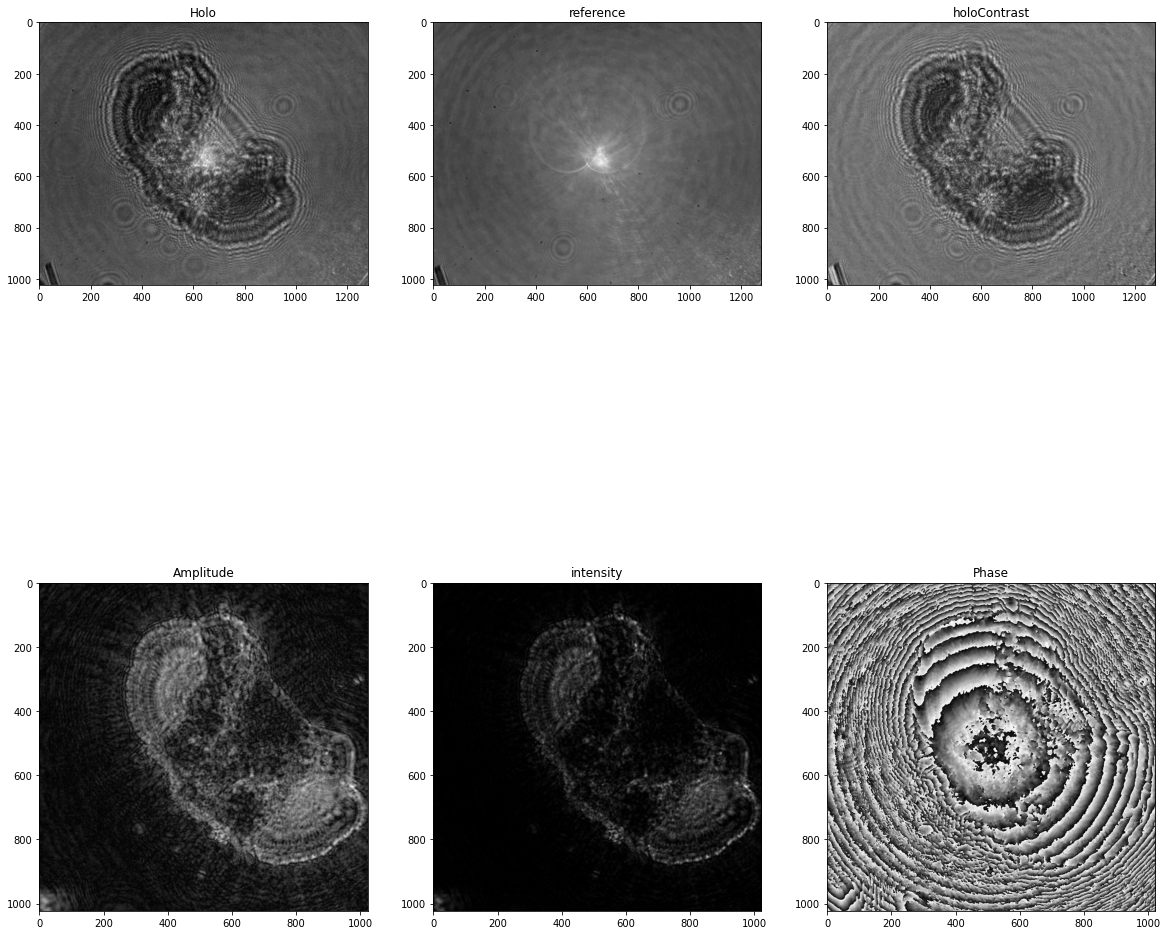

In [28]:
plt.figure(figsize=(20,20))
# filename='/content/holoMHDL512.bmp'
filename='/content/DrosophilaH.bmp'
# filename='/content/Paramecium_Holo.bmp'
holo=(plt.imread(filename)).astype(float)
shape=np.shape(holo)
fi = shape[0]
# filenameref='/content/refMHDL512.bmp'
filenameref='/content/DrosophilaRef.bmp'
# filenameref='/content/Paramecium_Reference.bmp'
ref=(plt.imread(filenameref)).astype(float)

holoContrast=holo - ref

plt.subplot(231)
plt.title('Holo')
plt.imshow(holo,cmap='gray')
plt.subplot(232)
plt.title('reference')
plt.imshow(ref,cmap='gray')
plt.subplot(233)
plt.title('holoContrast')
plt.imshow(holoContrast,cmap='gray')

#geometric features
z=2.2e-03
L=12e-03
lambda_=650e-09
dx=(0.006875) / fi



#pixel size at reconstruction plance
deltaX=(z*dx) / L
  
#cosenus filter creation
FC=filtcosenoF(100,fi)
#reconstrcut

start = time.time()
K=kreuzer3F(holoContrast,z,L,lambda_,dx,deltaX,FC,'save')
end = time.time()
print("time :",end - start)

amplitude = np.abs(K)
intensity = np.square(np.abs(K))
phase = np.angle(K)

plt.subplot(234)
plt.title('Amplitude')
plt.imshow(amplitude,cmap='gray')

plt.subplot(235)
plt.title('intensity')
plt.imshow(intensity,cmap='gray')

plt.subplot(236)
plt.title('Phase')
plt.imshow(phase,cmap='gray')

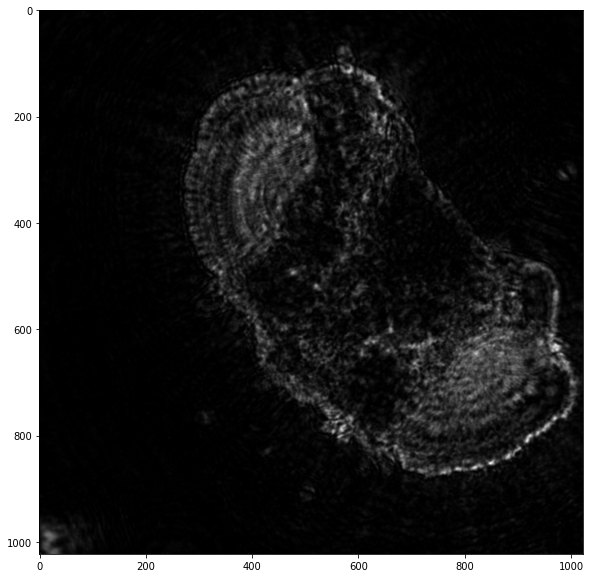

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(intensity,cmap='gray')

time : 33.14559197425842


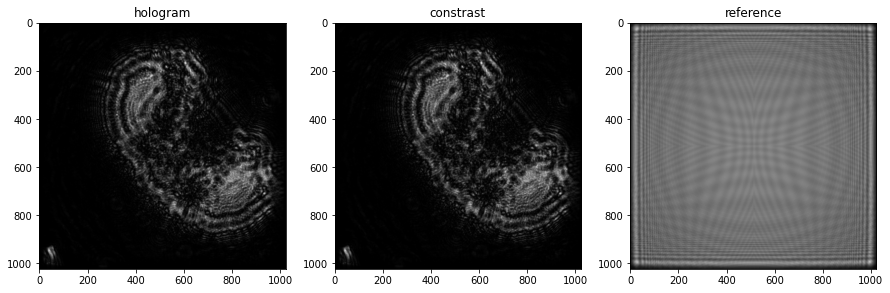

In [29]:
start = time.time()
hologram, reference, contrast, AN = dlhm_sim( K,z,L,lambda_,dx )
end = time.time()
print("time :",end - start)

fil = np.abs(hologram);

# save this image
MAXAmp = np.max(np.max(fil))
MINAmp = np.min(np.min(fil))
FileAmp = (fil- MINAmp)/(MAXAmp-MINAmp);
FileAmp = 255*FileAmp

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('hologram')
plt.imshow(np.abs(hologram),cmap='gray')

plt.subplot(132)
plt.title('constrast')
plt.imshow(np.abs(contrast),cmap='gray')

plt.subplot(133)
plt.title('reference')
plt.imshow(np.abs(reference),cmap='gray')







255


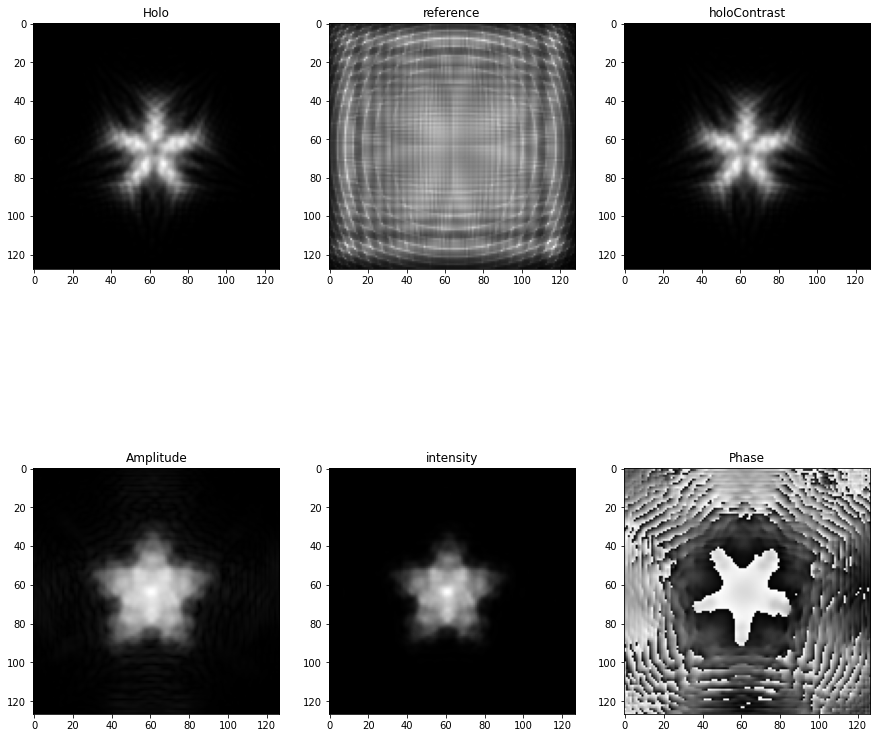

In [ ]:
plt.figure(figsize=(15,15))
# filename='/content/holoMHDL512.bmp'
samplename='/content/drive/My Drive/holography/hologramas/prueba1/star.png'
from PIL import Image, ImageOps
sample = (color.rgb2gray(io.imread(samplename)))

smallest = np.amin(sample)
biggest = np.amax(sample)
if biggest> 2 : 
  maximo = 255
else:
  maximo = 1
sample = maximo- sample
sample = (cv2.resize(sample, (128,128),interpolation = cv2.INTER_AREA))
print(maximo)
# print(biggest)
# sample=(plt.imread(samplename)).astype(float)
# sample = sample[0]
#geometric features
shape=np.shape(sample)

fi = shape[0]
# z=  7e-05
z=5e-05

L=0.12
lambda_=4.05e-07
dx=(0.12288) / fi

hologram, reference, contrast, AN = dlhm_sim( sample,z,L,lambda_,dx )


holoContrast=hologram - reference

plt.subplot(231)
plt.title('Holo')
plt.imshow(np.abs(hologram),cmap='gray')
plt.subplot(232)
plt.title('reference')
plt.imshow(np.abs(reference),cmap='gray')
plt.subplot(233)
plt.title('holoContrast')
plt.imshow(np.abs(contrast),cmap='gray')
#pixel size at reconstruction plance
deltaX=(z*dx) / L  
#cosenus filter creation
FC=filtcosenoF(100,fi)
#reconstrcut
K=kreuzer3F(holoContrast,z,L,lambda_,dx,deltaX,FC,'save')

amplitude = np.abs(K)
intensity = np.square(np.abs(K))
phase = np.angle(K)

plt.subplot(234)
plt.title('Amplitude')
plt.imshow(amplitude,cmap='gray')

plt.subplot(235)
plt.title('intensity')
plt.imshow(intensity,cmap='gray')

plt.subplot(236)
plt.title('Phase')
plt.imshow(phase,cmap='gray')


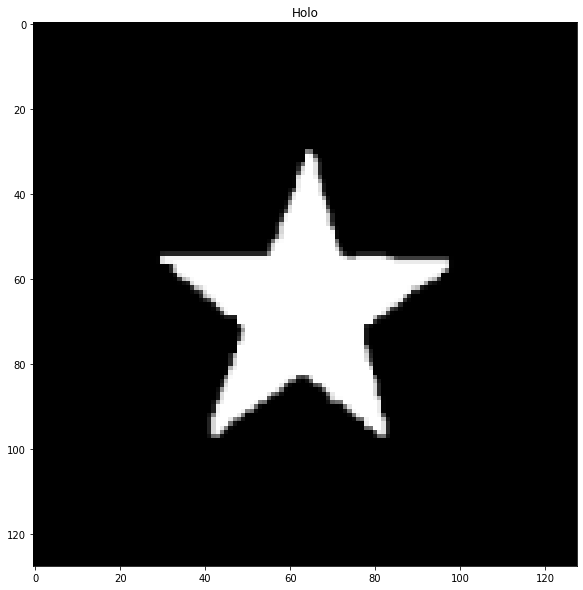

In [ ]:



plt.figure(figsize=(10,10))
plt.title('Holo')
plt.imshow(sample,cmap='gray')

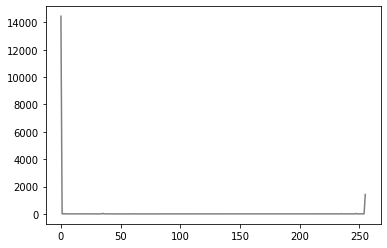

In [ ]:
hist = cv2.calcHist([sample], [0], None, [256], [0, 256])
plt.plot(hist, color='gray' )

In [ ]:
from skimage.color import rgb2gray
import warnings

def load_Apply_save(inputfolder,outputfolder,cut_image_folder):      
    cont2= 0
    for filename in os.listdir(inputfolder): 
        # try:  
          cont2 = cont2 + 1 
          img = color.rgb2gray(io.imread(os.path.join(inputfolder,filename)))
          
          smallest = np.amin(img)
          biggest = np.amax(img)
          if biggest> 2 : 
            maximo = 255
          else:
            maximo = 1
          img = maximo- img
          img_cut = (cv2.resize(img, (128,128),interpolation = cv2.INTER_AREA))
                
          z  = 2e-05
          cont =0
          
          while z <= 10e-05 :
          
              shape=np.shape(img_cut)
              fi = shape[0]                     
              L=0.12
              lambda_=4.05e-07
              dx=(0.12288) / fi
              plt.figure(cont)
            
              hologram, reference, contrast, AN = dlhm_sim(img_cut,z,L,lambda_,dx )
              src_fname, ext = os.path.splitext(filename)  # split filename and extension
              # construct output filename, basename to remove input directory
              # plt.imshow(np.abs(hologram))
              with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                save_fname = os.path.join(outputfolder, os.path.basename(src_fname)+str(cont)+ext)
                save_fcutname = os.path.join(cut_image_folder, os.path.basename(src_fname)+str(cont)+ext)
                io.imsave(save_fname, (np.abs(hologram)))
                io.imsave(save_fcutname, img_cut)
              cont = cont + 1
              z = z + 1e-05

        # except:
        #     print("An exception occurred")

In [ ]:
inputfolder = '/content/drive/My Drive/holography/hologramas/shapes/star'
outputfolder = '/content/drive/My Drive/holography/hologramas/datasetholo'
cutfolder = '/content/drive/My Drive/holography/hologramas/dataset_cut'
# inputfolder = '/content/drive/My Drive/holography/hologramas/prueba1'
# outputfolder = '/content/drive/My Drive/holography/hologramas/prueba2'
# cutfolder = '/content/drive/My Drive/holography/hologramas/prueba3'
# clear()

load_Apply_save(inputfolder,outputfolder,cutfolder)

Se truncaron las últimas líneas 5000 del resultado de transmisión.


In [ ]:
# source = '/content/drive/My Drive/holography/hologramas/prueba1'
# dest = '/content/drive/My Drive/holography/hologramas/move1'

# # !cp -R  /content/drive/'My Drive'/holography/hologramas /content/drive/'My Drive'/holography/hologramas/move1
# !cd  '/content/drive/My Drive/holography/hologramas'